# Punks Gen w/ Convolutional CVAE

In [1]:
import sys
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import matplotlib.pyplot as plt

%matplotlib inline


In [2]:
# Load pallets library

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from pallets import images as I, datasets as DS, models as M, logging as L


# Settings

In [3]:
SAVE_NAME = 'cvae.conv'

In [4]:
USE_GPU = True
LOG_LEVEL = 'INFO'
TEST_SIZE = 1000
EPOCHS = 50
LR = 3e-04
BATCH_SIZE = 32

LABELS_FILE = '../artifacts/pallets_labels.json'

In [5]:
# To GPU, or not to GPU
device = M.get_device(require_gpu=USE_GPU)

# Logging
L.init_logger(notebook=True)


<Logger pallets (INFO)>

## Prepare Datasets

In [6]:
# all_colors = I.get_punk_colors()
# mapper = DS.ColorOneHotMapper(all_colors)
# dataset = DS.OneHotCPunksDataset(
#     mapper, labels_file=LABELS_FILE, test_size=TEST_SIZE
# )
# torch.save(dataset, '../artifacts/onehot_ds_cpu.pt')

dataset = torch.load('../artifacts/onehot_ds_cpu.pt')

INFO | loading punk images
INFO | - image 0
INFO | - image 1000
INFO | - image 2000
INFO | - image 3000
INFO | - image 4000
INFO | - image 5000
INFO | - image 6000
INFO | - image 7000
INFO | - image 8000
INFO | - image 9000
INFO | punk images complete
INFO | loading punk labels: ../scripts/pallets_labels.json


In [7]:
train_sampler = SubsetRandomSampler(dataset.train_idx)
test_sampler = SubsetRandomSampler(dataset.test_idx)

train_loader = DataLoader(
    dataset, batch_size=BATCH_SIZE, sampler=train_sampler,
)
test_loader = DataLoader(
    dataset, batch_size=BATCH_SIZE, sampler=test_sampler,
)


## Convolutional CVAE

In [8]:
input_dim = 222
latent_dim = 32
classes_dim = 92

model = M.cvae.ConvCVAE(input_dim, latent_dim, classes_dim)
criterion = M.cvae.Loss()


In [9]:

train_losses, test_losses = M.cvae.train(
    device, model, criterion, train_loader, test_loader,
    learn_rate=LR, epochs=EPOCHS
)


INFO | model: pallets.models.cvae.ConvCVAE
INFO | criterion: pallets.models.cvae.Loss
INFO | learn rate: 0.0003
INFO | epochs: 50
INFO | epoch 1 (  0%) loss: 1417047.000000
INFO | epoch 1 ( 35%) loss: 158117.244682
INFO | epoch 1 ( 70%) loss: 87349.213158
INFO | epoch 1 (100%) loss: 66192.733606
INFO | epoch 1 (test) loss: 13016.098328
INFO | epoch 2 (  0%) loss: 13432.509766
INFO | epoch 2 ( 35%) loss: 13005.386438
INFO | epoch 2 ( 70%) loss: 12551.720863
INFO | epoch 2 (100%) loss: 12195.360380
INFO | epoch 2 (test) loss: 11105.471069
INFO | epoch 3 (  0%) loss: 11077.093750
INFO | epoch 3 ( 35%) loss: 11110.944858
INFO | epoch 3 ( 70%) loss: 10920.656925
INFO | epoch 3 (100%) loss: 10760.625437
INFO | epoch 3 (test) loss: 10054.503563
INFO | epoch 4 (  0%) loss: 10519.417969
INFO | epoch 4 ( 35%) loss: 10087.117197
INFO | epoch 4 ( 70%) loss: 9854.466768
INFO | epoch 4 (100%) loss: 9617.662887
INFO | epoch 4 (test) loss: 8735.941078
INFO | epoch 5 (  0%) loss: 8944.197266
INFO | epo

In [10]:
M.save(SAVE_NAME, model, train_losses, test_losses)

INFO | model blob saved to /home/jmsdnns/ML/pallets/saved/cvae.conv.pkl
INFO | training losses saved to /home/jmsdnns/ML/pallets/saved/cvae.conv.json


# Model Output to Image

In [11]:
# model, train_losses, test_losses = M.load(SAVE_NAME, device)
# model = model.to(device)


#

In [12]:
import random
import json

raw_labels = json.load(open("../artifacts/pallets_labels.json"))
label_keys = [k for k in raw_labels["0"].keys()]

def rand_label():
    label_idx = int(random.random() * len(dataset._labels))
    features = dataset._labels[label_idx]
    enabled_names = [k for k,v in zip(label_keys, features) if v.item() == 1]
    return features.to(device), enabled_names


In [13]:
# Generate new image

def rand_punk():
    z = torch.randn(1, latent_dim).to(device)
    # print(z.shape)
    features, names = rand_label()
    print(f"Features: {', '.join(names)}")

    with torch.no_grad():
        model.eval()
        generated_image = model.decoder(z, features.unsqueeze(0))
        # print(generated_image.shape)

    decoded_one_hot = generated_image[0]
    decoded_one_hot = decoded_one_hot.view((222, 24, 24))
    # print(decoded_one_hot.shape)
    decoded = DS.one_hot_to_rgba(decoded_one_hot, dataset.mapper)
    print(f"Shape: {decoded.shape}")
    return decoded


### 5 Randoms

Features: male, crazyHair, hornedRimGlasses
Shape: torch.Size([4, 24, 24])
torch.Size([4, 24, 24])


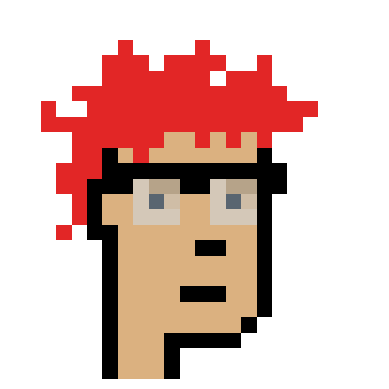

In [28]:
decoded = rand_punk()
print(decoded.shape)

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


Features: male, frown, mohawk, bigShades, earring
Shape: torch.Size([4, 24, 24])


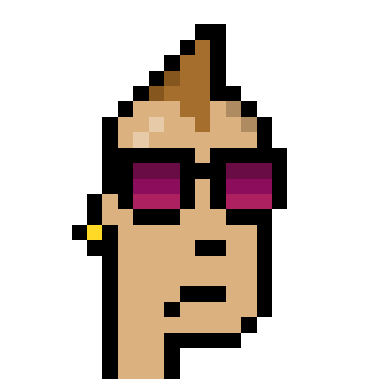

In [29]:
decoded = rand_punk()

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


Features: male, policeCap, eyePatch, earring
Shape: torch.Size([4, 24, 24])


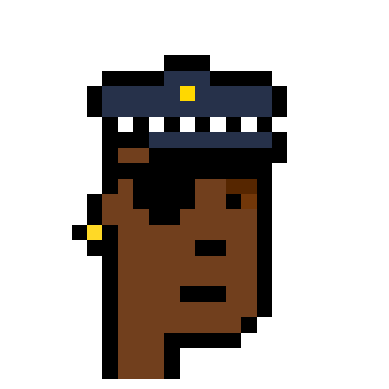

In [30]:
decoded = rand_punk()

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


Features: female, wildBlonde, purpleEyeShadow, hotLipstick
Shape: torch.Size([4, 24, 24])


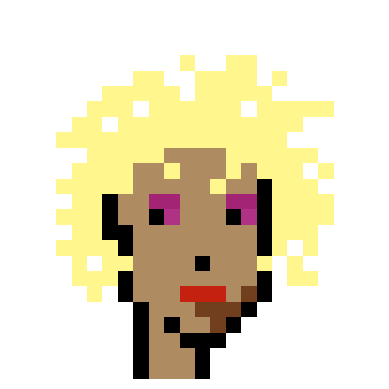

In [31]:
decoded = rand_punk()

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


Features: male, hoodie, clownEyesBlue
Shape: torch.Size([4, 24, 24])


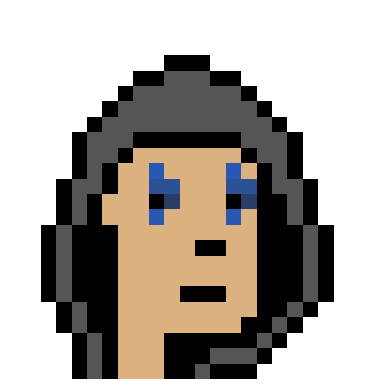

In [32]:
decoded = rand_punk()

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


## Reconstruction

In [19]:
def reconstruct_punk(idx):
    punk = I.get_punk_tensor(idx)
    p = DS.rgba_to_one_hot(punk, dataset.mapper)
    p = p.unsqueeze(0)
    p = p.to(device)

    _, labels = dataset[idx]
    l = labels.unsqueeze(0)
    l = l.to(device)
    enabled_features = [k for k,v in zip(label_keys, labels) if v.item() == 1]

    model.eval()
    with torch.no_grad():
        reconstructed, mu, logvar = model.forward(p, l)

    recon_punk = reconstructed[0].cpu()
    recon_punk = DS.one_hot_to_rgba(recon_punk, dataset.mapper)

    return punk, recon_punk, enabled_features


def draw_two(img1, img2):
    page_size = 2
    view_x, view_y = 4*page_size, 2*page_size
    fig = plt.figure(figsize=(view_x, view_y))
    fig.add_subplot(1, 2, 1)
    plt.imshow(transforms.functional.to_pil_image(img1))
    plt.axis('off')
    fig.add_subplot(1, 2, 2)
    plt.imshow(transforms.functional.to_pil_image(img2))
    plt.axis('off')
    plt.show()


### 5 Recons

Features: female, rosyCheeks, darkHair, cigarette


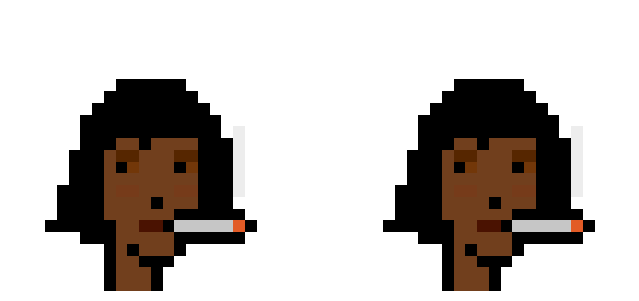

In [33]:
punk, recon_punk, features = reconstruct_punk(1000)

print(f"Features: {', '.join(features)}")
draw_two(punk, recon_punk)

Features: female, stringyHair, purpleLipstick, earring


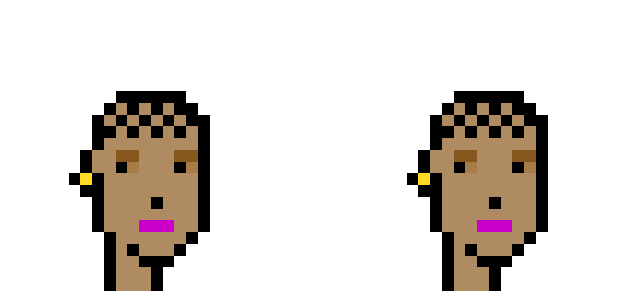

In [34]:
punk, recon_punk, features = reconstruct_punk(2001)

print(f"Features: {', '.join(features)}")
draw_two(punk, recon_punk)


Features: female, wildWhiteHair, greenEyeShadow, hotLipstick


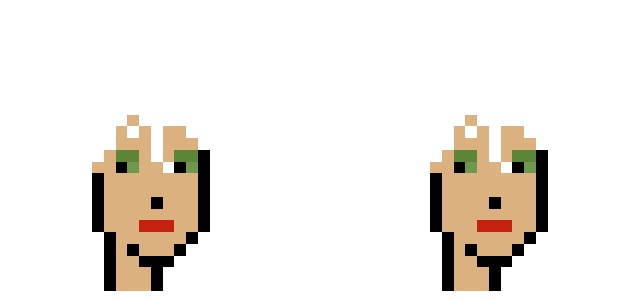

In [35]:
punk, recon_punk, features = reconstruct_punk(5000)

print(f"Features: {', '.join(features)}")
draw_two(punk, recon_punk)

Features: male, rosyCheeks, mustache, vr, cap, cigarette


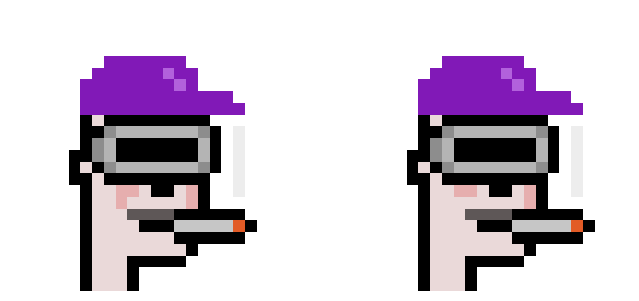

In [36]:
punk, recon_punk, features = reconstruct_punk(8000)

print(f"Features: {', '.join(features)}")
draw_two(punk, recon_punk)

Features: male, handlebars, bandana


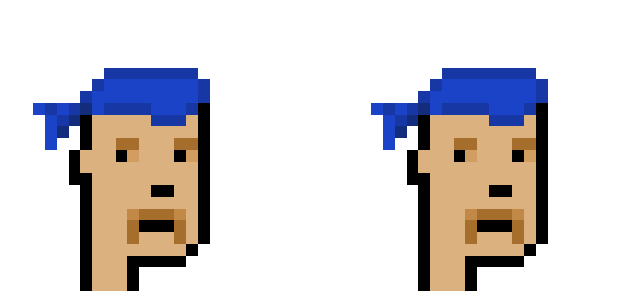

In [37]:
punk, recon_punk, features = reconstruct_punk(1337)

print(f"Features: {', '.join(features)}")
draw_two(punk, recon_punk)

# Testing

<function matplotlib.pyplot.show(close=None, block=None)>

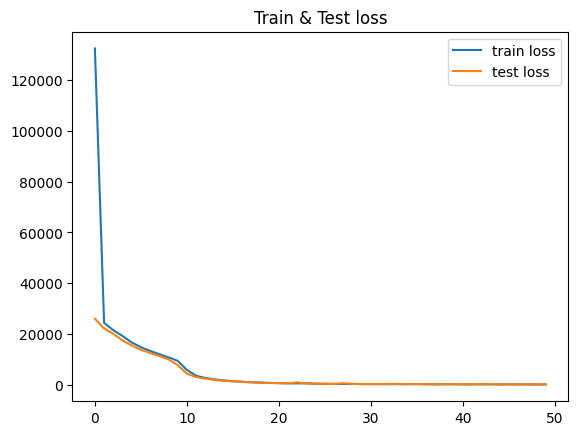

In [25]:
plt.title("Train & Test loss")
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show


In [26]:
train_losses


[132385.46721243352,
 24390.720760264296,
 21521.250874404366,
 19235.325773631426,
 16677.6581477172,
 14817.605520694813,
 13362.840124251994,
 12064.941640001662,
 10819.324283681017,
 9448.897272204676,
 5852.502233843431,
 3582.6482881586603,
 2713.1887877985096,
 2133.6903580469443,
 1741.7283929053774,
 1447.901715001316,
 1209.0032836697626,
 1015.8349751141054,
 864.6003791322099,
 739.6478536619362,
 653.4100681602532,
 579.0926501767855,
 560.4521587182444,
 629.2628127294229,
 432.40110659768396,
 388.6022259326691,
 365.64135240324845,
 329.8795226076816,
 366.9188644463289,
 286.4401871836777,
 269.2055006365404,
 263.64097942866334,
 258.32383322208483,
 257.57999739410184,
 255.4310039763755,
 303.39206046246466,
 228.04790699735602,
 200.37466584875227,
 208.73478881348956,
 228.98986004768534,
 173.00945675626716,
 176.1548520487251,
 217.93745665854595,
 177.0425247300601,
 160.8625980268979,
 193.20099478917766,
 179.24305727803116,
 187.4272034827699,
 145.77828953

In [27]:
test_losses


[26032.196655273438,
 22210.942138671875,
 20109.007125854492,
 17471.88215637207,
 15504.205673217773,
 13782.320556640625,
 12518.64468383789,
 11324.772438049316,
 10042.12215423584,
 7759.146556854248,
 4398.221298217773,
 3066.5861167907715,
 2425.064688682556,
 1949.9381046295166,
 1612.5725631713867,
 1350.3945293426514,
 1154.7392673492432,
 1001.7209434509277,
 850.961745262146,
 767.004322052002,
 691.6093063354492,
 594.8950262069702,
 969.7606706619263,
 495.8885545730591,
 475.7963833808899,
 425.61687994003296,
 383.39335322380066,
 625.6976156234741,
 358.82721161842346,
 322.24400806427,
 315.8005847930908,
 327.4309115409851,
 331.1605393886566,
 356.05994272232056,
 290.8125627040863,
 289.30795907974243,
 240.68167805671692,
 225.49767184257507,
 262.5894923210144,
 234.14873576164246,
 211.9600771665573,
 219.18858885765076,
 243.72159814834595,
 277.2456600666046,
 171.6990739107132,
 191.63014554977417,
 176.57431268692017,
 190.7369064092636,
 184.84855151176453,